# Part 1: Team ranking

In [1]:
using LinearAlgebra, DelimitedFiles
A = readdlm("games.csv", ',', Float32);
teams = readdlm("teams.csv", ',');

# This function takes in a vector containing ranking for each team, and
# output the names of the top k teams sorted by ranking
function sort_by_ranking(rankings; k=10)
    @assert length(rankings) == length(teams)
            "$(length(rankings)) rankings != $(length(teams)) teams"
    indices = sort(1:length(rankings), by = i -> -rankings[i])
    return collect(Iterators.take(zip(rankings[indices], teams[indices]), k))
end

sort_by_ranking (generic function with 1 method)

In [2]:
Q = copy(A)
for i = 1:size(Q, 1)
    Q[i,:] /= sum(Q[i,:]) + sum(Q[:,i]) # entry Q_ij is A_ij / sum(A_i)
end

# To find v_1 we use the Power Iteration method
r = rand(Float64, size(Q, 1)) # start with "random" initial vector (nonzero along v_1)
for k = 1:250
    r = normalize(Q*r)  # r converges to eigenvector r_1 as k-> infinity: multiply by Q and then normalize
end
sort_by_ranking(r, k=20)

 



20-element Vector{Tuple{Float64, Any}}:
 (0.33446785419317926, "Oklahoma")
 (0.31218159280812846, "Baylor")
 (0.27369995991642265, "Kansas State")
 (0.25241740070445623, "Texas")
 (0.21718776830164824, "TCU")
 (0.20608379542911184, "West Virginia")
 (0.1889884826873755, "Oklahoma State")
 (0.1785377814374456, "Iowa State")
 (0.17515748124742406, "Texas Tech")
 (0.14990546578268837, "LSU")
 (0.1246185556132705, "Georgia")
 (0.1224965201619617, "Oregon")
 (0.12048148943327094, "Florida")
 (0.11947234170211368, "Ohio State")
 (0.1182005631948373, "Iowa")
 (0.11579708574207434, "Utah")
 (0.11467837376150249, "Clemson")
 (0.1135034195157856, "Miami")
 (0.11045927844973216, "Wisconsin")
 (0.10744565697930131, "Tennessee")

# Part 2

In [3]:
using Plots
using LinearAlgebra

## 2b

In [4]:
function getA(a, b)
    n = length(a)
    @assert a + b == ones(n) "Probabilities do not sum to 1!"

    A = zeros(Float64, n, n)
    # first equation p_1 is the first two entries of a
    A[1,1] = a[1]
    A[1,2] = a[2]

    # for entries k 2 <= k <= n-1, p_k = a*p_k-1 + b*p_k+1
    for i = 2 : n-1
        A[i, i-1] = b[i-1]
        A[i, i+1] = a[i+1]
    end

    # similar to p_1, p_n is a result of the last two entries of b
    A[n, n-1] = b[n-1]
    A[n,n] = b[n]

    
    return A    
end

A = getA(ones(4)/3, ones(4)*2/3)
display(A)


4×4 Matrix{Float64}:
 0.333333  0.333333  0.0       0.0
 0.666667  0.0       0.333333  0.0
 0.0       0.666667  0.0       0.333333
 0.0       0.0       0.666667  0.666667

## 2c

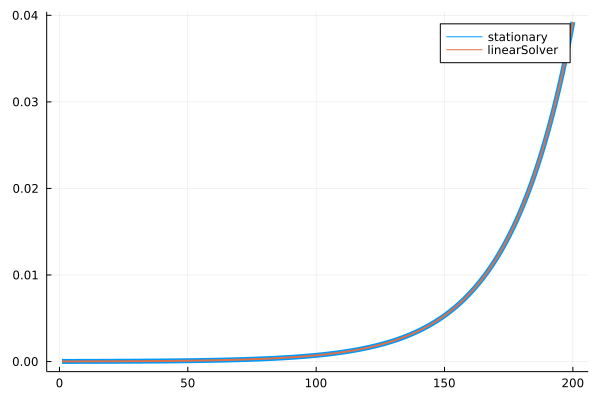

In [10]:
function stationary(a, b)
    A = getA(a,b)
    eigen_decomp = eigen(A)
    e_vecs = eigen_decomp.vectors   # gather the eigenvectors
    e_vals = eigen_decomp.values    # gather the eigenvalues
    l1 = 0

    # loop through the eigenvalues
    for i = 1:length(e_vals)
        if abs(e_vals[i] - 1) < 0.000001    # giving tolerance for floats
            l1 = i  # find index of eigenvalue 1
            break
        end
    end
    v1 = abs.(e_vecs[:, l1])    # get the associated eigenvector
    return v1/sum(v1)   # normalize the eigenvector
end

function linearSolver(a,b)
    # Ap = p
    # Ap - p = 0
    # (A-I)p = 0
    # the vector p is the nullspace of (A-I) normalized
    A = getA(a,b)
    A = A - (Matrix{Float64}(I, length(a), length(a))) # calculate A-I
    result = nullspace(A)   # calculate nullspace vector
    return result/sum(result)   # return normalized version

end

plot(stationary(fill(.49, 200), fill(.51, 200)), label = "stationary", linewidth=5)
plot!(linearSolver(fill(.49, 200), fill(.51, 200)), label = "linearSolver", linewidth=2)


## 2d

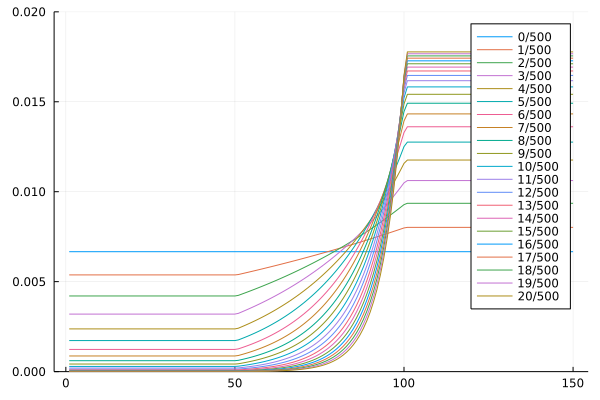

In [11]:
function generate_barrier(l, w; eps=0.1)
    a = [ones(l)*1/2; ones(w)*(1/2-eps); ones(l)*1/2]
    b = [ones(l)*1/2; ones(w)*(1/2+eps); ones(l)*1/2]
    a,b
end

plot()
for i in 0:20
    a, b = generate_barrier(50, 50, eps = i/500)
    plot!(stationary(a,b), label = string(i)*"/500")
    
end
plot!(legend=true,ylim=(0,0.02))

## 2e

┌ Info: Saved animation to 
│   fn = c:\Users\donav\Desktop\18C06\tmp.gif
└ @ Plots C:\Users\donav\.julia\packages\Plots\FCUr0\src\animation.jl:137


Plots.AnimatedGif("c:\\Users\\donav\\Desktop\\18C06\\tmp.gif")
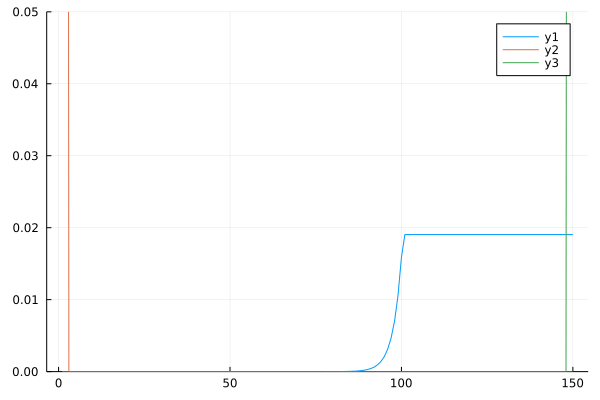

In [12]:
function animtime(a, b, xinit, niters)
    x = xinit
    A = getA(a,b)
    fig = @gif for i in 1:niters
        x = A*x
        plot(x, ylim=(0,.05))
    end every 50
    fig
end

a,b = generate_barrier(50, 50; eps=0.1)
x_stationary  =  stationary(a,b)
x_leftmost    =  zeros(150)
x_leftmost[1] = 1
x_rightmost   =  zeros(150)
x_rightmost[150] = 1
animtime(a, b, [x_stationary x_leftmost x_rightmost], 5000)

## 2f

Plots.AnimatedGif("c:\\Users\\donav\\Desktop\\18C06\\tmp.gif")
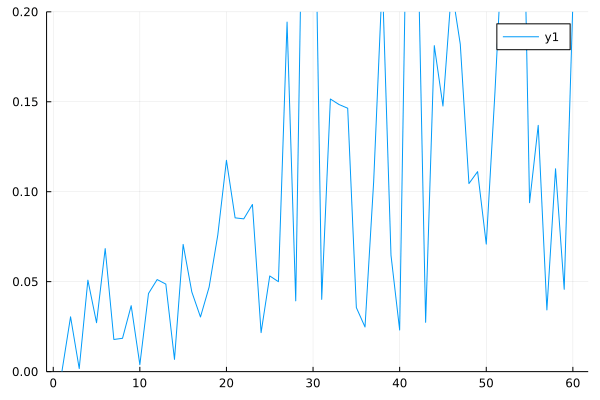

┌ Info: Saved animation to 
│   fn = c:\Users\donav\Desktop\18C06\tmp.gif
└ @ Plots C:\Users\donav\.julia\packages\Plots\FCUr0\src\animation.jl:137


In [13]:
function animtimevecs(a, b, xinit, niters)
    x = xinit
    A = getA(a,b)
    vec = eigvecs(A,sortby=abs)
    fig = @gif for i in 1:niters
        x = A*x
        b = vec\x
        plot(abs.(b), ylim=(0,.2))
    end every 5
    fig
end

a, b = generate_barrier(20, 20; eps=0.1)
x = abs.(randn(length(a)))
animtimevecs(a, b, x/sum(x), 500)